In [34]:
import json
import os
from datetime import datetime, timedelta
from math import atan2, cos, degrees, radians, sqrt
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point

from railroad import custom_json_decoder, load_graph, plot_node_graph
from utils import print_graph_info

In [35]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance (in meters) between two geographical points.
    """
    R = 6371000  # Radius of Earth in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    d_phi = radians(lat2 - lat1)
    d_lambda = radians(lon2 - lon1)

    a = np.sin(d_phi / 2)**2 + cos(phi1) * cos(phi2) * np.sin(d_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [36]:
def verify_unique_train_time_pairs(df):
    """
    Verify that each train_id and current_time pair is unique in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing train positions with 'train_id' and 'current_time' columns.

    Returns:
        bool: True if all train_id and current_time pairs are unique, False otherwise.
        pd.DataFrame: DataFrame containing any duplicate entries, if found.
    """
    # Group by 'train_id' and 'current_time' and count occurrences
    duplicates = df.groupby(['train_id', 'current_time']
                            ).size().reset_index(name='count')

    # Filter rows where count > 1, indicating duplicates
    duplicates = duplicates[duplicates['count'] > 1]

    if duplicates.empty:
        print("Verification passed: All train_id and current_time pairs are unique.")
        return True, None
    else:
        print("Verification failed: Duplicate train_id and current_time pairs found.")
        return False, duplicates

In [37]:
# Load the JSON data from the file
with open('../data/railroad_simulation_2029.json', 'r') as f:
    railroad_simulation_data = json.load(f, object_hook=custom_json_decoder)
# Extract the first 5 items from the dictionary
first_2_items = dict(list(railroad_simulation_data.items())[:2])
print(first_2_items)

{'2029-02-01T16:00:00': {'graph': {'directed': True, 'multigraph': False, 'graph': {}, 'nodes': [{'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 1848219055', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120), 'station_coordinates': (64.0856269, -21.8096127), 'id': 0}, {'street_count': 3, 'geometry': <POINT (-21.844 64.09)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 602729079', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120), 'station_coordinates': (64.0897624, -21.8438709), 'id': 1}, {'street_count': 3, 'geometry': <POINT (-21.872 64.099)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 111465687', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120)

In [38]:
# Extract the first timeframe
first_timeframe_key = list(railroad_simulation_data.keys())[0]
graph_data = railroad_simulation_data[first_timeframe_key]["graph"]
print(graph_data)
G = nx.node_link_graph(graph_data)
print_graph_info(G)

{'directed': True, 'multigraph': False, 'graph': {}, 'nodes': [{'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 1848219055', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120), 'station_coordinates': (64.0856269, -21.8096127), 'id': 0}, {'street_count': 3, 'geometry': <POINT (-21.844 64.09)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 602729079', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120), 'station_coordinates': (64.0897624, -21.8438709), 'id': 1}, {'street_count': 3, 'geometry': <POINT (-21.872 64.099)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True, 'station_name': 'Station 111465687', 'waiting_time': datetime.timedelta(seconds=60), 'transfer_time': datetime.timedelta(seconds=120), 'station_coordinates': (64.09920

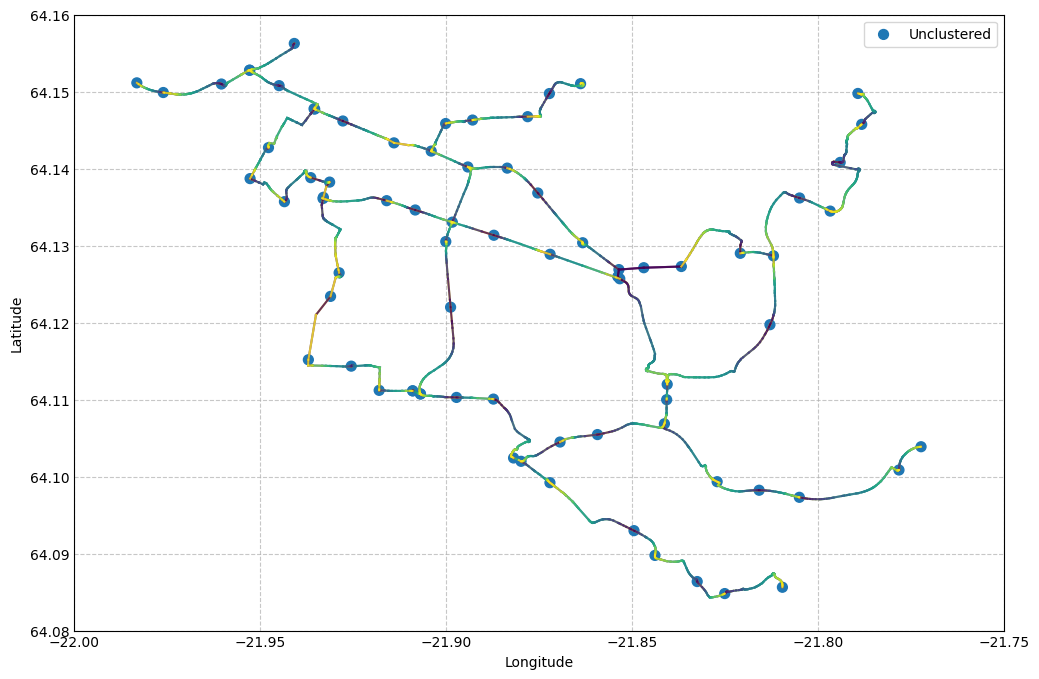

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [39]:
plot_node_graph(G, color_segments=True)

In [40]:
G

In [41]:
for id_in, id_out, data in G.edges(data=True):
    in_geom = G.nodes[id_in]["geometry"]
    out_geom = G.nodes[id_out]["geometry"]
    path = data['geometry']

    if in_geom.distance(Point(path.coords[0])) < out_geom.distance(Point(path.coords[0])):
        pass
        # print('all good')
    else:
        print('in ', in_geom, 'out ', out_geom, 'path ', path)
        print(Point(path.coords[0]))
        print(Point(path.coords[-1]))
        G[id_in][id_out]['geometry'] = LineString(path.coords[::-1])
        print('reversed')
        print(in_geom.distance(Point(path.coords[0])), out_geom.distance(
            Point(path.coords[0])))
        print(G[id_in][id_out]['geometry'])
        if Point(path.coords[0]) == in_geom:
            print('all good')
        else:
            print('reversed fucked')
            G[id_in][id_out]['geometry'] = LineString((in_geom, out_geom))

In [42]:
for id_in, id_out, data in G.edges(data=True):
    in_geom = G.nodes[id_in]["geometry"]
    out_geom = G.nodes[id_out]["geometry"]
    path = data['geometry']
    if Point(path.coords[0]) == in_geom:
        pass
        # print('all good')
    else:
        print('not good')

In [43]:
# Create GeoDataFrame for stations
stations_gdf = gpd.GeoDataFrame(
    [
        {
            "station_id": node,
            "station_name": data["station_name"],
            "waiting_time": data["waiting_time"],
            "transfer_time": data["transfer_time"],
            "geometry": data["geometry"],  # Use preprocessed geometry
        }
        for node, data in G.nodes(data=True)
    ],
    crs="EPSG:4326",
)

# Create GeoDataFrame for connections
connections_gdf = gpd.GeoDataFrame(
    [
        {
            "source": u,
            "target": v,
            "length": data.get("length", None),
            "travel_time": data.get("travel_time", None),
            "oneway": data.get("oneway", False),
            "geometry": data["geometry"],  # Use preprocessed geometry
        }
        for u, v, data in G.edges(data=True)
    ],
    crs="EPSG:4326",
)

# Combine the cleaned GeoDataFrames
combined_gdf = gpd.GeoDataFrame(
    pd.concat([stations_gdf, connections_gdf], ignore_index=True)
)

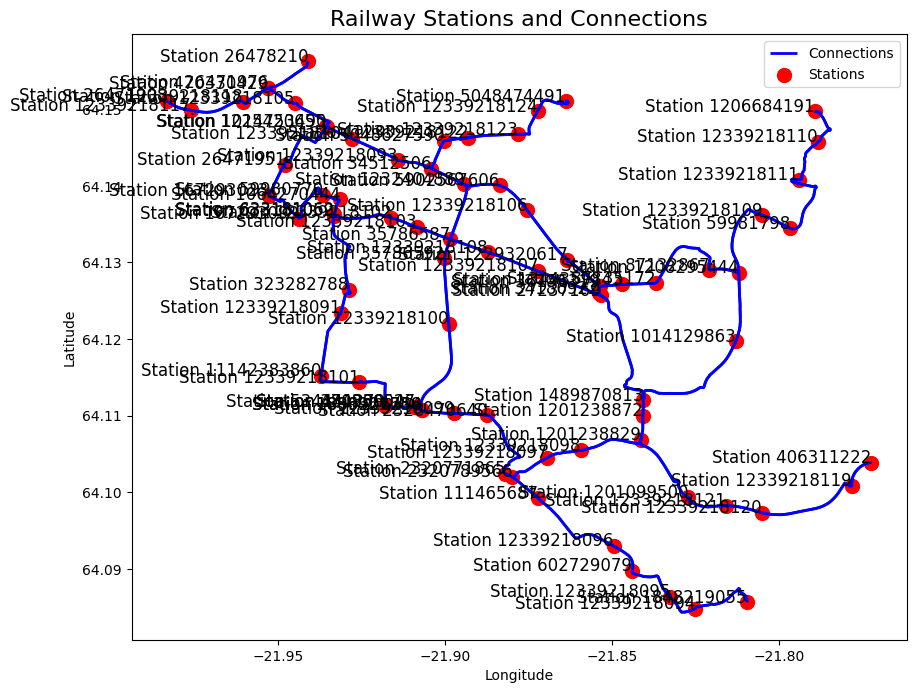

In [44]:

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot connections (lines)
connections_gdf.plot(ax=ax, color="blue", linewidth=2, label="Connections")

# Plot stations (points)
stations_gdf.plot(ax=ax, color="red", markersize=100, label="Stations")

# Annotate station names
for x, y, label in zip(
    stations_gdf.geometry.x, stations_gdf.geometry.y, stations_gdf["station_name"]
):
    ax.text(x, y, label, fontsize=12, ha="right")

# Customize the plot
ax.set_title("Railway Stations and Connections", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show the plot
plt.show()

In [45]:
def process_train_data(train_data, graph, current_time):
    """
    Process train data and compute the position of a train at the given time.
    Format all fields to be compatible with GeoJSON storage.

    Args:
        train_data (dict): Train data from JSON.
        graph (nx.Graph): Railroad graph with edges and nodes.
        current_time (str): Current timestamp in ISO format.

    Returns:
        dict: Processed train data with position, coordinates, and all fields formatted for GeoJSON.
    """

    current_time = current_time

    train_id = train_data.get("train_id")
    current_station = train_data["current_station"]
    previous_station = train_data["previous_station"]
    next_station = train_data["next_station"]
    previous_departure_time = train_data["previous_departure_time"]
    next_arrival_time = train_data["next_arrival_time"]

    # Initialize the result with all train data fields
    result = train_data.copy()

    if current_station is not None:  # At a station
        coordinates = graph.nodes[current_station]["station_coordinates"]
        result.update({
            "train_id": train_id,
            # Flip to (lon, lat)
            "coordinates": Point(coordinates[1], coordinates[0]),
            "status": "at_station",
        })
    elif previous_station is None:  # At the first station
        coordinates = graph.nodes[next_station]["station_coordinates"]
        result.update({
            "train_id": train_id,
            # Flip to (lon, lat)
            "coordinates": Point(coordinates[1], coordinates[0]),
            "status": "at_station",
        })
    else:  # Between stations
        edge = graph[previous_station][next_station]
        line = edge["geometry"]  # LineString of the track
        travel_time = (next_arrival_time -
                       previous_departure_time).total_seconds()
        elapsed_time = (current_time - previous_departure_time).total_seconds()
        progress_fraction = min(
            max(elapsed_time / travel_time, 0), 1)  # Clamp to [0, 1]

        # Compute the train's position along the LineString
        train_position = line.interpolate(progress_fraction, normalized=True)
        result.update({
            "train_id": train_id,
            # Keep as (lon, lat)
            "coordinates": Point(train_position.x, train_position.y),
            "status": "on_track",
            "progress": progress_fraction,
        })

    # Extract latitude and longitude from the Shapely Point
    if result.get("coordinates"):
        result['longitude'] = result["coordinates"].x
        result['latitude'] = result["coordinates"].y

    # Convert list and dictionary fields to JSON strings for GeoJSON compatibility
    for key in ['schedule', "route", "passengers_on_board", "style"]:
        if isinstance(result.get(key), (list, dict)):
            result[key] = str(result[key])

    # Convert None values to empty strings for GeoJSON compatibility
    for key, value in result.items():
        if value is None:
            result[key] = ""

    return result

In [46]:
railroad_simulation_data.keys()

dict_keys(['2029-02-01T16:00:00', '2029-02-01T16:00:30', '2029-02-01T16:01:00', '2029-02-01T16:01:30', '2029-02-01T16:02:00', '2029-02-01T16:02:30', '2029-02-01T16:03:00', '2029-02-01T16:03:30', '2029-02-01T16:04:00', '2029-02-01T16:04:30', '2029-02-01T16:05:00', '2029-02-01T16:05:30', '2029-02-01T16:06:00', '2029-02-01T16:06:30', '2029-02-01T16:07:00', '2029-02-01T16:07:30', '2029-02-01T16:08:00', '2029-02-01T16:08:30', '2029-02-01T16:09:00', '2029-02-01T16:09:30', '2029-02-01T16:10:00', '2029-02-01T16:10:30', '2029-02-01T16:11:00', '2029-02-01T16:11:30', '2029-02-01T16:12:00', '2029-02-01T16:12:30', '2029-02-01T16:13:00', '2029-02-01T16:13:30', '2029-02-01T16:14:00', '2029-02-01T16:14:30', '2029-02-01T16:15:00', '2029-02-01T16:15:30', '2029-02-01T16:16:00', '2029-02-01T16:16:30', '2029-02-01T16:17:00', '2029-02-01T16:17:30', '2029-02-01T16:18:00', '2029-02-01T16:18:30', '2029-02-01T16:19:00', '2029-02-01T16:19:30', '2029-02-01T16:20:00', '2029-02-01T16:20:30', '2029-02-01T16:21:00', 

In [47]:

# Extract all train data for each timeframe
train_positions = []
for timeframe, data in railroad_simulation_data.items():
    current_time = data["current_time"]
    trains = data["trains"]

    for train_id, train_data in trains.items():
        # print(f"Processing train {train_id} at {current_time}...")
        # Add train ID to the data for processing

        # print("Train data:")
        # print(train_data)
        train_data["train_id"] = train_id
        # Compute train position and add to results
        processed_data = process_train_data(train_data, G, current_time)
        # Add timeframe and current time to the processed data
        processed_data["timeframe"] = datetime.fromisoformat(timeframe)
        processed_data["current_time"] = current_time
        # print("Processed:")
        # print(processed_data)
        # print()
        train_positions.append(processed_data)

# Convert the processed train positions into a pandas DataFrame
train_positions_df = pd.DataFrame(train_positions)
# display(train_positions_df)

In [48]:
# Usage example
is_unique, duplicate_entries = verify_unique_train_time_pairs(
    train_positions_df)

# If duplicates are found, print them and raise an exception
if not is_unique:
    print("Duplicate Train ID and Time Pairs Found:")
    print(duplicate_entries)
    raise ValueError(
        "Verification failed: Duplicate train_id and current_time pairs exist in the DataFrame.")

Verification passed: All train_id and current_time pairs are unique.


In [49]:
def add_previous_next_indices(df):
    """
    Add columns for previous and next indices, timestamps, and coordinates to a DataFrame,
    while preserving the original index.

    Args:
        df (pd.DataFrame): Input DataFrame containing train positions.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns for previous and next indices.
    """
    # Copy the DataFrame to avoid modifying the original
    df = df.copy()

    # Add an explicit original_index column to track the current index
    df["original_index"] = df.index

    # Sort by train_id and timeframe to ensure correct ordering
    df = df.sort_values(by=["train_id", "timeframe"])

    # Initialize new columns
    df["previous_index"] = None
    df["next_index"] = None
    df["previous_timestamp"] = None
    df["next_timestamp"] = None
    df["previous_coords"] = None
    df["next_coords"] = None

    # Group by train_id to process each train separately
    for train_id, group in df.groupby("train_id"):
        # Ensure the original index is used for calculations
        original_indices = group["original_index"]

        # Use shift to calculate previous and next indices
        df.loc[group.index, "previous_index"] = original_indices.shift(1)
        df.loc[group.index, "next_index"] = original_indices.shift(-1)

        # Use shift to calculate previous and next timestamps and coordinates
        df.loc[group.index, "previous_timestamp"] = group["timeframe"].shift(1)
        df.loc[group.index, "next_timestamp"] = group["timeframe"].shift(-1)

        df.loc[group.index, "previous_coords"] = group["coordinates"].shift(1)
        df.loc[group.index, "next_coords"] = group["coordinates"].shift(-1)

    # Ensure previous/next indices remain integers (or NaN for the first/last row)
    df["previous_index"] = df["previous_index"].astype("Int64")
    df["next_index"] = df["next_index"].astype("Int64")

    # Ensure previous/next timestamps are in datetime format
    df["previous_timestamp"] = pd.to_datetime(df["previous_timestamp"])
    df["next_timestamp"] = pd.to_datetime(df["next_timestamp"])

    return df


train_positions_df = add_previous_next_indices(train_positions_df)

In [50]:
# train_positions_df = train_positions_df.reset_index(drop=True)

In [51]:
# Access row by label
print(train_positions_df.loc[201])

schedule                   [{'arrival_time': datetime.datetime(2029, 2, 1...
capacity                                                                  50
number_of_stations                                                        77
route                      [23, 61, 21, 22, 21, 20, 19, 18, 17, 18, 19, 2...
route_name                                                                g2
status                                                            at_station
at_station                                                             False
number_of_passengers                                                       0
current_event_index                                                        0
current_station_index                                                       
previous_station                                                            
current_station                                                             
next_station                                                              23

In [52]:
train_positions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 10 to 3619
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   schedule                 3630 non-null   object        
 1   capacity                 3630 non-null   int64         
 2   number_of_stations       3630 non-null   int64         
 3   route                    3630 non-null   object        
 4   route_name               3630 non-null   object        
 5   status                   3630 non-null   object        
 6   at_station               3630 non-null   bool          
 7   number_of_passengers     3630 non-null   int64         
 8   current_event_index      3630 non-null   int64         
 9   current_station_index    3630 non-null   object        
 10  previous_station         3630 non-null   object        
 11  current_station          3630 non-null   object        
 12  next_station             3630 non-null

In [53]:
def compute_speed_and_yaw(train_positions_df, postfix=""):
    """
    Compute speed vector, yaw, yaw change rate, and total speed for train positions.

    Args:
        train_positions_df (pd.DataFrame): DataFrame containing train position data.
        postfix (str): String to append to the names of the computed fields (default is "").

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns.
    """
    # Define column names with postfix
    speed_x_col = f"speed_x{postfix}"
    speed_y_col = f"speed_y{postfix}"
    yaw_col = f"yaw{postfix}"
    yaw_change_rate_col = f"yaw_change_rate{postfix}"
    speed_col = f"speed{postfix}"
    latitude_col = f"latitude{postfix}"
    longitude_col = f"longitude{postfix}"

    # Add new columns for speed vector, yaw, yaw change rate, and total speed
    train_positions_df[speed_x_col] = np.nan
    train_positions_df[speed_y_col] = np.nan
    train_positions_df[yaw_col] = np.nan
    train_positions_df[yaw_change_rate_col] = np.nan
    train_positions_df[speed_col] = np.nan

    # Iterate over all rows
    for index, row in train_positions_df.iterrows():
        current_index = row.name
        next_index = row["next_index"]
        previous_index = row["previous_index"]

        # Determine the comparison row: next if available, otherwise previous
        if not pd.isna(next_index):
            comparison_index = int(next_index)
        elif not pd.isna(previous_index):
            comparison_index = int(previous_index)
        else:
            # Skip rows without previous or next points
            continue

        # Get the comparison row
        comparison_row = train_positions_df.loc[comparison_index]

        # Calculate time difference in seconds
        time_diff = abs(row["current_time"] - comparison_row["current_time"])
        time_diff_seconds = time_diff.total_seconds()

        if time_diff_seconds > 0:
            # Calculate distances using Haversine formula
            distance = haversine_distance(
                row[latitude_col], row[longitude_col],
                comparison_row[latitude_col], comparison_row[longitude_col]
            )

            # Calculate speed (m/s) and convert to km/h
            speed = (distance / time_diff_seconds) * 3.6

            # Calculate speed components (x and y)
            delta_x = comparison_row[longitude_col] - row[longitude_col]
            delta_y = comparison_row[latitude_col] - row[latitude_col]

            # Normalize deltas for direction
            if delta_x != 0:
                speed_x = delta_x / abs(delta_x) * speed
            else:
                speed_x = 0

            if delta_y != 0:
                speed_y = delta_y / abs(delta_y) * speed
            else:
                speed_y = 0

            # Calculate yaw (angle in degrees)
            yaw = degrees(atan2(delta_y, delta_x))

            # Update current row with speed, yaw, and speed components
            train_positions_df.loc[current_index, speed_x_col] = speed_x
            train_positions_df.loc[current_index, speed_y_col] = speed_y
            train_positions_df.loc[current_index, yaw_col] = yaw
            train_positions_df.loc[current_index, speed_col] = speed

            # Calculate yaw change rate (absolute value accounting for wraparound)
            if not pd.isna(previous_index):
                previous_row = train_positions_df.loc[int(previous_index)]
                previous_yaw = previous_row[yaw_col]

                if not pd.isna(previous_yaw):
                    yaw_diff = abs((yaw - previous_yaw + 180) %
                                   360 - 180)  # Wraparound handling
                    yaw_change_rate = yaw_diff / time_diff_seconds
                    train_positions_df.loc[current_index,
                                           yaw_change_rate_col] = yaw_change_rate

    return train_positions_df


# Apply the computation
train_positions_df = compute_speed_and_yaw(train_positions_df)

In [54]:
train_positions_df.loc[201]

schedule                   [{'arrival_time': datetime.datetime(2029, 2, 1...
capacity                                                                  50
number_of_stations                                                        77
route                      [23, 61, 21, 22, 21, 20, 19, 18, 17, 18, 19, 2...
route_name                                                                g2
status                                                            at_station
at_station                                                             False
number_of_passengers                                                       0
current_event_index                                                        0
current_station_index                                                       
previous_station                                                            
current_station                                                             
next_station                                                              23

In [55]:
print(
    f"{(train_positions_df[train_positions_df['status'] == 'at_station'])['speed'].max() = }")
print(
    f"{abs((train_positions_df[train_positions_df['status'] == 'at_station'])['speed']).min() = }")

(train_positions_df[train_positions_df['status'] == 'at_station'])['speed'].max() = 15.683484079148823
abs((train_positions_df[train_positions_df['status'] == 'at_station'])['speed']).min() = 0.0


In [56]:
print(
    f"{(train_positions_df[train_positions_df['status'] != 'at_station'])['speed'].max() = }")
print(
    f"{abs((train_positions_df[train_positions_df['status'] != 'at_station'])['speed']).min() = }")

(train_positions_df[train_positions_df['status'] != 'at_station'])['speed'].max() = 16.098314429257904
abs((train_positions_df[train_positions_df['status'] != 'at_station'])['speed']).min() = 0.0033134605544096513


In [57]:
print(f'{train_positions_df["speed"].max() = }')
print(f'{abs(train_positions_df["speed"]).min() = }')

train_positions_df["speed"].max() = 16.098314429257904
abs(train_positions_df["speed"]).min() = 0.0


In [58]:
print(train_positions_df.loc[201])

schedule                   [{'arrival_time': datetime.datetime(2029, 2, 1...
capacity                                                                  50
number_of_stations                                                        77
route                      [23, 61, 21, 22, 21, 20, 19, 18, 17, 18, 19, 2...
route_name                                                                g2
status                                                            at_station
at_station                                                             False
number_of_passengers                                                       0
current_event_index                                                        0
current_station_index                                                       
previous_station                                                            
current_station                                                             
next_station                                                              23

In [59]:
print(f'{train_positions_df.latitude.max()=}')
print(f'{train_positions_df.latitude.min()=}')
print(f'{train_positions_df.longitude.max()=}')
print(f'{train_positions_df.longitude.min()=}')

train_positions_df.latitude.max()=64.1562498
train_positions_df.latitude.min()=64.0843305391843
train_positions_df.longitude.max()=-21.7723411
train_positions_df.longitude.min()=-21.9831528


In [60]:

def interpolate_stuck_coordinates(prev_time_coord, next_time_coord, stuck_coord, stuck_times):
    """
    Interpolate coordinates for consecutive steps where the train is stuck at the same point
    using a LineString with three points: previous, stuck, and next coordinates.

    Args:
        prev_time_coord (tuple): (time when the coordinate was last different, coordinate as Point).
        next_time_coord (tuple): (time when the coordinate is next different, coordinate as Point).
        stuck_coord (Point): The stuck coordinate.
        stuck_times (list): List of timestamps when the train was stuck.

    Returns:
        list: List of interpolated coordinates for the stuck times.
    """
    prev_time, prev_coord = prev_time_coord
    next_time, next_coord = next_time_coord

    # Ensure timestamps are sorted
    stuck_times = sorted(stuck_times)

    stuck_times_diff = np.array([(t2-t1).total_seconds()
                                 for t1, t2 in zip([prev_time] + stuck_times, stuck_times+[next_time])])
    assert np.all(stuck_times_diff ==
                  30), f"Stuck times are not 30 seconds apart as expected: {stuck_times_diff}"

    # Create a LineString using previous, stuck, and next coordinates
    line = LineString([prev_coord, stuck_coord, next_coord])

    # Total time range for interpolation
    total_time = (next_time - prev_time).total_seconds()

    # Interpolated coordinates
    interpolated_coords = []

    for stuck_time in stuck_times:
        current_time = stuck_time
        # Fraction of time passed relative to the interval
        time_diff = (current_time - prev_time).total_seconds()
        time_fraction = time_diff / total_time

        # Interpolate along the LineString
        interpolated_point = line.interpolate(time_fraction, normalized=True)
        interpolated_coords.append(interpolated_point)

    return interpolated_coords

In [61]:
from shapely.geometry import Point

# Test data
prev_time_coord = (datetime.fromisoformat(
    "2029-02-01T19:04:30"), Point(-21.85, 64.12))
next_time_coord = (datetime.fromisoformat(
    "2029-02-01T19:07:30"), Point(-21.84, 64.13))
stuck_coord = Point(-21.85, 64.12)
stuck_times = [
    datetime.fromisoformat("2029-02-01T19:05:00"),
    datetime.fromisoformat("2029-02-01T19:05:30"),
    datetime.fromisoformat("2029-02-01T19:06:00"),
    datetime.fromisoformat("2029-02-01T19:06:30"),
    datetime.fromisoformat("2029-02-01T19:07:00"),
]

# Run interpolation
interpolated = interpolate_stuck_coordinates(
    prev_time_coord, next_time_coord, stuck_coord, stuck_times)

# Output results
for time, coord in zip(stuck_times, interpolated):
    print(f"Time: {time}, Interpolated Coord: ({coord.x:.6f}, {coord.y:.6f})")

Time: 2029-02-01 19:05:00, Interpolated Coord: (-21.848333, 64.121667)
Time: 2029-02-01 19:05:30, Interpolated Coord: (-21.846667, 64.123333)
Time: 2029-02-01 19:06:00, Interpolated Coord: (-21.845000, 64.125000)
Time: 2029-02-01 19:06:30, Interpolated Coord: (-21.843333, 64.126667)
Time: 2029-02-01 19:07:00, Interpolated Coord: (-21.841667, 64.128333)


In [62]:
def apply_interpolation_to_dataframe(df):
    """
    Apply interpolation for stuck coordinates in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing train positions.

    Returns:
        pd.DataFrame: Updated DataFrame with interpolated coordinates.
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Create new columns for interpolated coordinates
    df["longitude_interpolated"] = df["longitude"]
    df["latitude_interpolated"] = df["latitude"]

    # Group by train_id to process each train separately
    for train_id, group in df.groupby("train_id"):
        print(f"\nProcessing train_id: {train_id}")

        # Ensure the group is sorted by timeframe
        group = group.sort_values(by="timeframe").reset_index(drop=True)

        n = len(group)
        i = 0
        while i < n:
            row = group.iloc[i]
            current_coords = row["coordinates"]
            stuck_indices = [i]
            stuck_times = [row["timeframe"]]

            # Check subsequent rows for stuck coordinates
            j = i + 1
            while j < n and group.iloc[j]["coordinates"] == current_coords:
                stuck_indices.append(j)
                stuck_times.append(group.iloc[j]["timeframe"])
                j += 1

            if len(stuck_indices) > 1:
                # We have a stuck interval
                # Get previous coordinate
                if i > 0:
                    prev_row = group.iloc[i - 1]
                    prev_time_coord = (
                        prev_row["timeframe"], prev_row["coordinates"])
                else:
                    print(
                        f"Cannot interpolate for train_id {train_id}, index {group.iloc[i]['original_index']}: No previous coordinate available.")
                    i = j
                    continue

                # Get next coordinate
                if j < n:
                    next_row = group.iloc[j]
                    next_time_coord = (
                        next_row["timeframe"], next_row["coordinates"])
                else:
                    print(
                        f"Cannot interpolate for train_id {train_id}, indices {stuck_indices}: No next coordinate available.")
                    i = j
                    continue

                # Perform interpolation
                print(f"\nTrain ID: {train_id}")
                print(f"Stuck interval detected: {stuck_times}")
                print(f"Input to interpolate_stuck_coordinates:")
                print(
                    f"  prev_time_coord: {prev_time_coord[0]}, {prev_time_coord[1]}")
                print(
                    f"  next_time_coord: {next_time_coord[0]}, {next_time_coord[1]}")
                print(f"  stuck_coord: {current_coords}")

                interpolated_coords = interpolate_stuck_coordinates(
                    prev_time_coord,
                    next_time_coord,
                    current_coords,
                    stuck_times,
                )

                # Update DataFrame with interpolated coordinates
                for idx_stuck, coord in zip(stuck_indices, interpolated_coords):
                    save_index = group.iloc[idx_stuck]["original_index"]
                    df.loc[save_index, "longitude_interpolated"] = coord.x
                    df.loc[save_index, "latitude_interpolated"] = coord.y

                # Move i to j to skip over the stuck interval
                i = j
            else:
                # No stuck interval
                i += 1

    return df


# Apply interpolation to the train_positions_df
train_positions_df = apply_interpolation_to_dataframe(train_positions_df)


Processing train_id: b1_0
Cannot interpolate for train_id b1_0, index 10: No previous coordinate available.

Train ID: b1_0
Stuck interval detected: [Timestamp('2029-02-01 16:06:30'), Timestamp('2029-02-01 16:07:00')]
Input to interpolate_stuck_coordinates:
  prev_time_coord: 2029-02-01 16:06:00, POINT (-21.837846607130082 64.12726486837543)
  next_time_coord: 2029-02-01 16:07:30, POINT (-21.836728655858842 64.12732033822996)
  stuck_coord: POINT (-21.8367869 64.1272812)

Train ID: b1_0
Stuck interval detected: [Timestamp('2029-02-01 16:16:30'), Timestamp('2029-02-01 16:17:00')]
Input to interpolate_stuck_coordinates:
  prev_time_coord: 2029-02-01 16:16:00, POINT (-21.820931559697236 64.12911712650339)
  next_time_coord: 2029-02-01 16:17:30, POINT (-21.819920439732034 64.12906625364253)
  stuck_coord: POINT (-21.8209295 64.1289974)

Train ID: b1_0
Stuck interval detected: [Timestamp('2029-02-01 16:21:30'), Timestamp('2029-02-01 16:22:00')]
Input to interpolate_stuck_coordinates:
  pre

In [63]:
# Apply the computation
train_positions_df = compute_speed_and_yaw(train_positions_df)
train_positions_df = compute_speed_and_yaw(
    train_positions_df, postfix="_interpolated")

In [64]:
print(train_positions_df.loc[201])

schedule                        [{'arrival_time': datetime.datetime(2029, 2, 1...
capacity                                                                       50
number_of_stations                                                             77
route                           [23, 61, 21, 22, 21, 20, 19, 18, 17, 18, 19, 2...
route_name                                                                     g2
status                                                                 at_station
at_station                                                                  False
number_of_passengers                                                            0
current_event_index                                                             0
current_station_index                                                            
previous_station                                                                 
current_station                                                                  
next_station    

In [65]:
print(f'{train_positions_df["speed"].max() = }')
print(f'{abs(train_positions_df["speed"]).min() = }')

train_positions_df["speed"].max() = 16.098314429257904
abs(train_positions_df["speed"]).min() = 0.0


In [66]:
columns_to_save = [
    "train_id", "timeframe", "current_time", "number_of_passengers", "route_name", "status", "current_station",
    "previous_station", "next_station", "longitude", "latitude", "longitude_interpolated", "latitude_interpolated", "speed", "speed_x",
    "speed_y", "yaw", "yaw_change_rate", "speed_interpolated", "speed_x_interpolated", "speed_y_interpolated", "yaw_interpolated", "yaw_change_rate_interpolated"
]

# Save the DataFrame to CSV
train_positions_df[columns_to_save].to_csv(
    "../data/trains_2029.csv", index=False)